# Customer churn - Telco

## import and settings

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

**Plotty setting**

In [ ]:
# Set Plotly as Pandas plotting backend

pd.options.plotting.backend = "plotly"
np.set_printoptions(precision=2, suppress=True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format

## Data collection

In [ ]:

# הורדת הדאטהסט מקגל
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

# קריאת הקובץ
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")


Path to dataset files: /kaggle/input/telco-customer-churn


**Dataframe Info**

In [ ]:

# הצגת מידע ראשוני
print(df.head())
print(df.info())
print(df.describe(include="all"))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### **Missing values**

In [ ]:
# בדיקה של חוסרים
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### **Target values counter**


חלוקת target - Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


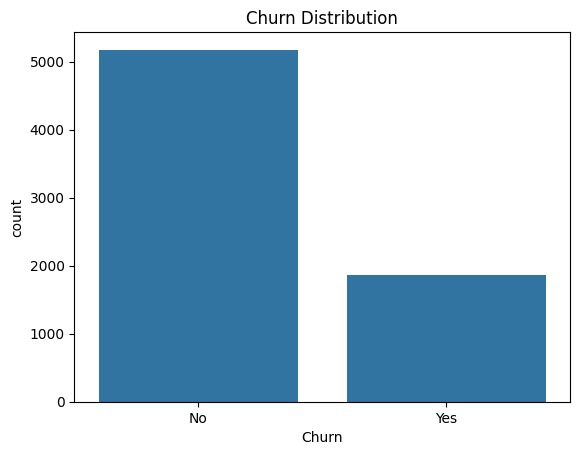

In [ ]:
#  בדיקת חלוקת target 'Churn' ===
print("\nחלוקת target - Churn:")
print(df['Churn'].value_counts())
# גרף חלוקת churn
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

### **convert Strings to numbers if necessary**

In [ ]:
import pandas as pd
import numpy as np

def clean_object_numeric(df, fill_numeric=np.nan):
    """
    מנקה עמודות מסוג object:
    - מסיר רווחים מסביב למחרוזת
    - מחליף מחרוזות ריקות ב-NaN
    - מנסה להמיר למספר (float)
    - אם לא ניתן, נשאר object
    - ניתן לציין fill_numeric לערכים ריקים אחרי המרה (default NaN)

    מחזיר DataFrame חדש.
    """
    df = df.copy()
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()

    for col in obj_cols:
        # מסיר רווחים מסביב למחרוזת
        df[col] = df[col].astype(str).str.strip()

        # רווחים ריקים הופכים ל-NaN
        df[col].replace('', np.nan, inplace=True)

        # מנסה להמיר למספר
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
            # מילוי ערכים ריקים אם רוצים
            if fill_numeric is not np.nan:
                df[col].fillna(fill_numeric, inplace=True)
            print(f"Column '{col}' converted to numeric")
        except:
            # לא ניתן להמיר → נשאר object
            print(f"Column '{col}' kept as object")

    return df


In [ ]:
df = clean_object_numeric(df, fill_numeric=0)


Column 'customerID' kept as object
Column 'gender' kept as object
Column 'Partner' kept as object
Column 'Dependents' kept as object
Column 'PhoneService' kept as object
Column 'MultipleLines' kept as object
Column 'InternetService' kept as object
Column 'OnlineSecurity' kept as object
Column 'OnlineBackup' kept as object
Column 'DeviceProtection' kept as object
Column 'TechSupport' kept as object
Column 'StreamingTV' kept as object
Column 'StreamingMovies' kept as object
Column 'Contract' kept as object
Column 'PaperlessBilling' kept as object
Column 'PaymentMethod' kept as object
Column 'TotalCharges' converted to numeric
Column 'Churn' kept as object


/tmp/ipython-input-3448738498.py:23: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-3448738498.py:23: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or

### **Feature engineering**

In [ ]:
import pandas as pd
import numpy as np

def fe_total_charges(df, col='TotalCharges', n_bins=15):
    """
    מנקה את העמודה TotalCharges, ממיר לכל float, ממלא ערכים חסרים ב-0.
    מוסיף עמודות עם bins של TotalCharges.
    מחזיר df עם העמודה המקורית מעודכנת ועמודות הבינים.
    """
    df = df.copy()

    # החלפת רווחים או empty string ל-NaN
    df[col] = df[col].replace(" ", np.nan)

    # המרה ל-float
    df[col] = df[col].astype(float)

    # מילוי NaN ב-0 (אפשר גם עם median או mean)
    df[col] = df[col].fillna(0)

    # יצירת bins
    bin_labels = [f'{col}_bin_{i}' for i in range(n_bins)]
    df_bins = pd.get_dummies(pd.cut(df[col], bins=n_bins, labels=bin_labels, include_lowest=True))

    # איחוד עם df המקורי
    df = pd.concat([df, df_bins], axis=1)

    print(f"Feature Engineering done for '{col}': converted to float and added {n_bins} bins.")
    return df

# שימוש
df = fe_total_charges(df, col='TotalCharges', n_bins=15)


Feature Engineering done for 'TotalCharges': converted to float and added 15 bins.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7043 non-null   object 
 1   gender               7043 non-null   object 
 2   SeniorCitizen        7043 non-null   int64  
 3   Partner              7043 non-null   object 
 4   Dependents           7043 non-null   object 
 5   tenure               7043 non-null   int64  
 6   PhoneService         7043 non-null   object 
 7   MultipleLines        7043 non-null   object 
 8   InternetService      7043 non-null   object 
 9   OnlineSecurity       7043 non-null   object 
 10  OnlineBackup         7043 non-null   object 
 11  DeviceProtection     7043 non-null   object 
 12  TechSupport          7043 non-null   object 
 13  StreamingTV          7043 non-null   object 
 14  StreamingMovies      7043 non-null   object 
 15  Contract             7043 non-null   o

###**Print distributions**

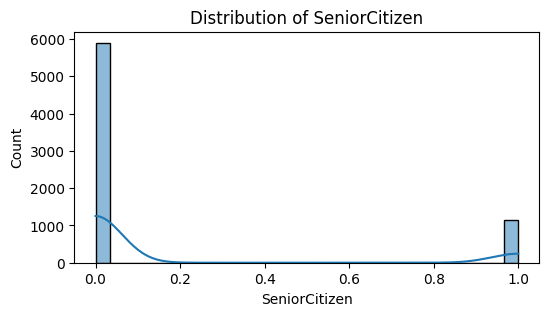

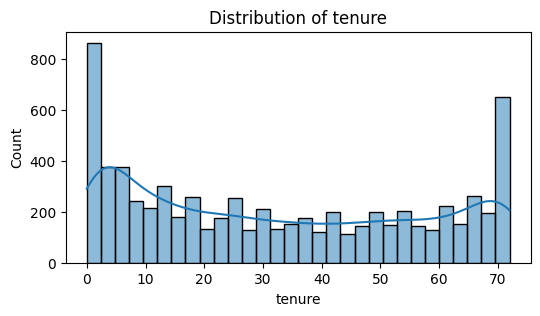

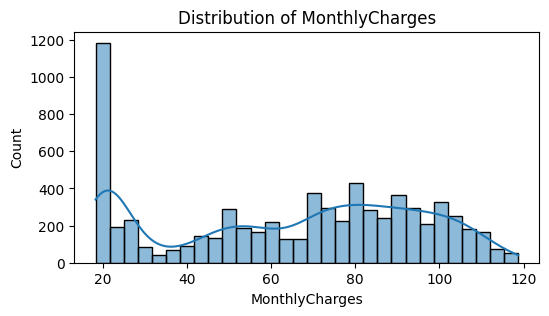

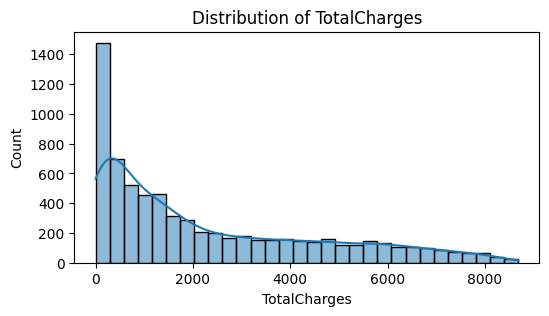

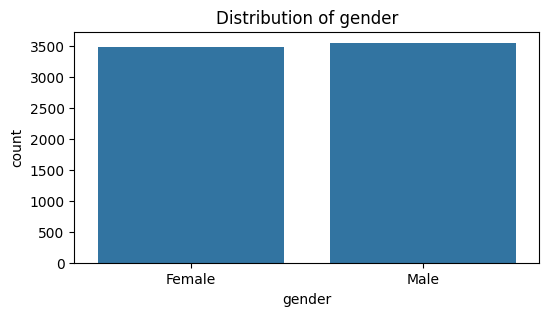

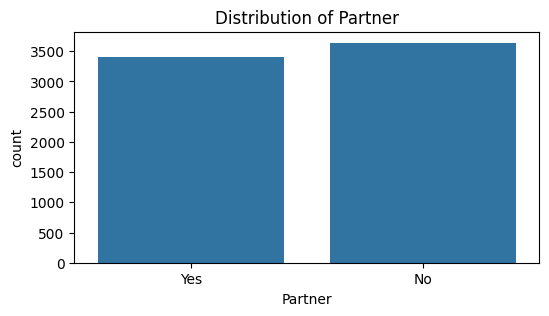

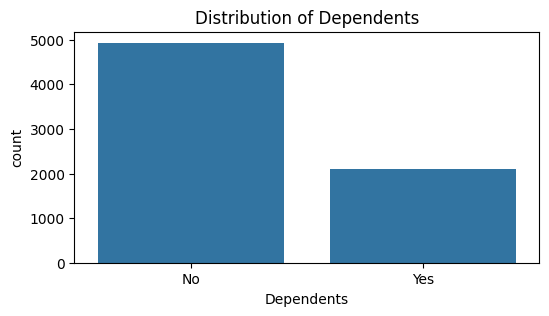

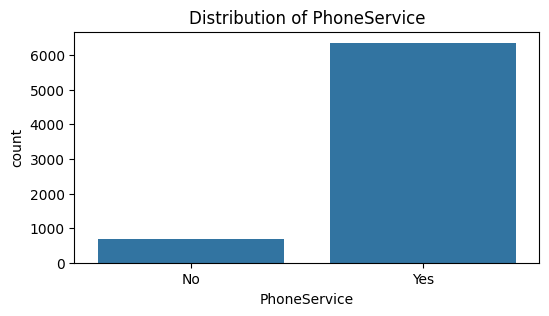

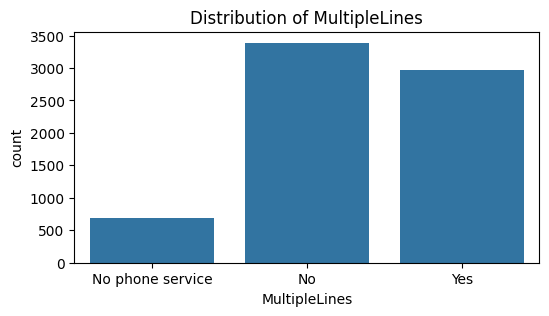

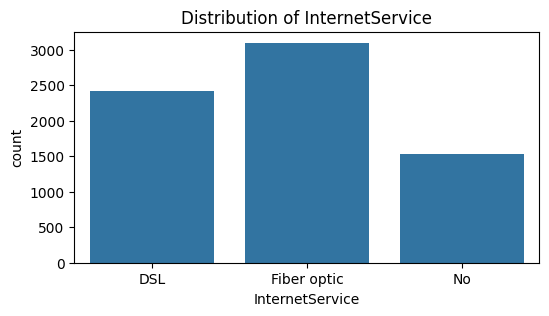

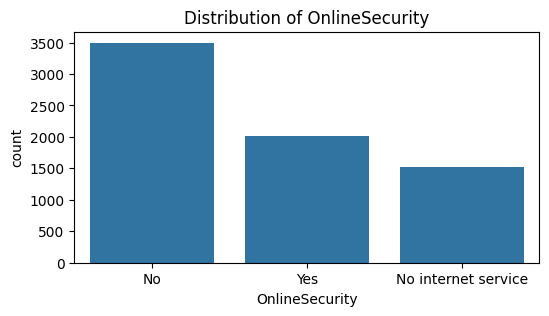

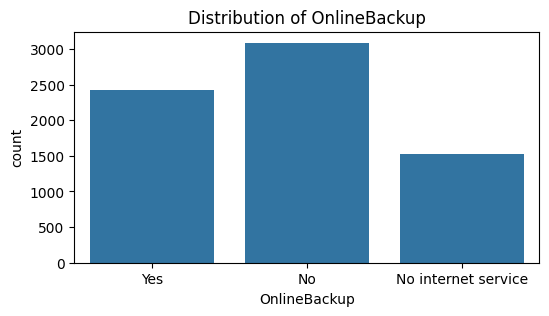

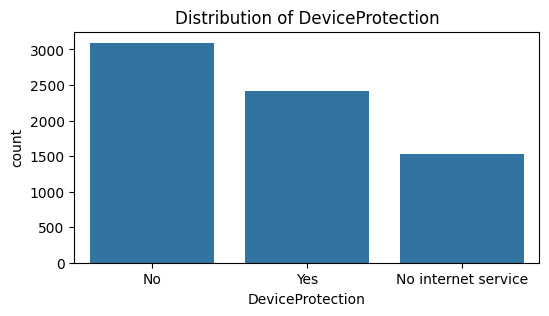

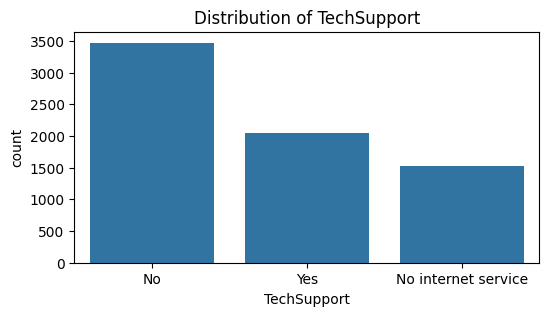

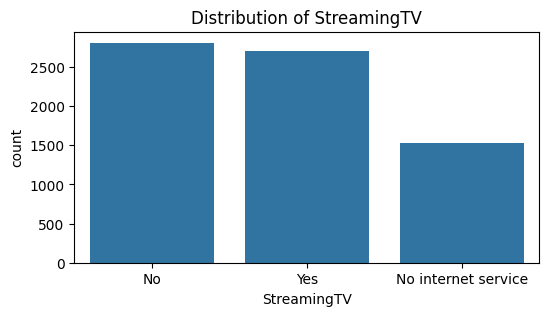

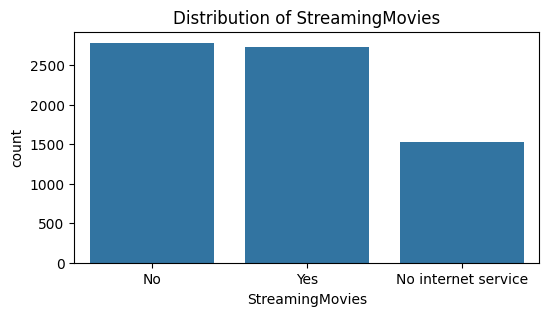

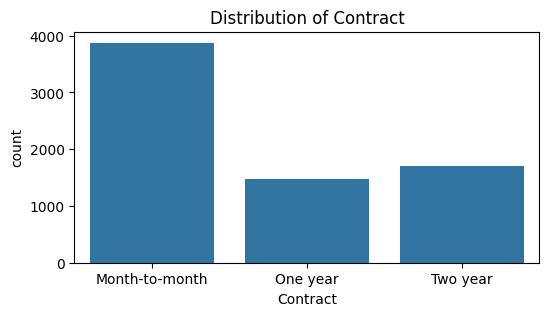

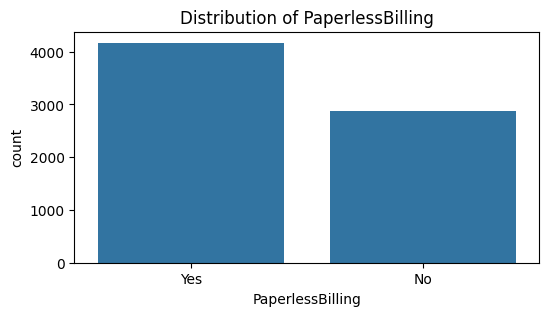

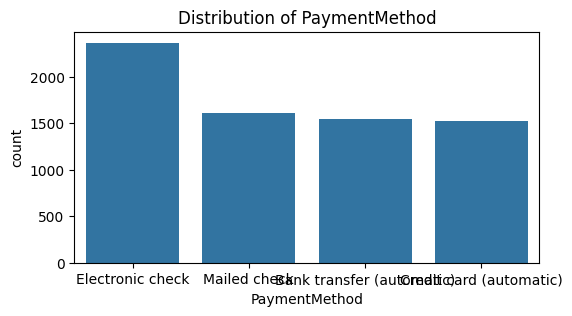

In [ ]:
df.drop(columns=['customerID'], inplace=True)
# מספריות: כל סוגי int ו-float
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# קטגוריות: כל סוגי object ו-category
target = 'Churn'
cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c != target]

# גרפים בסיסיים על פיצ'רים מספריים
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# גרפים בסיסיים על פיצ'רים קטגוריאליים
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

### **Correlation between Numberical features**

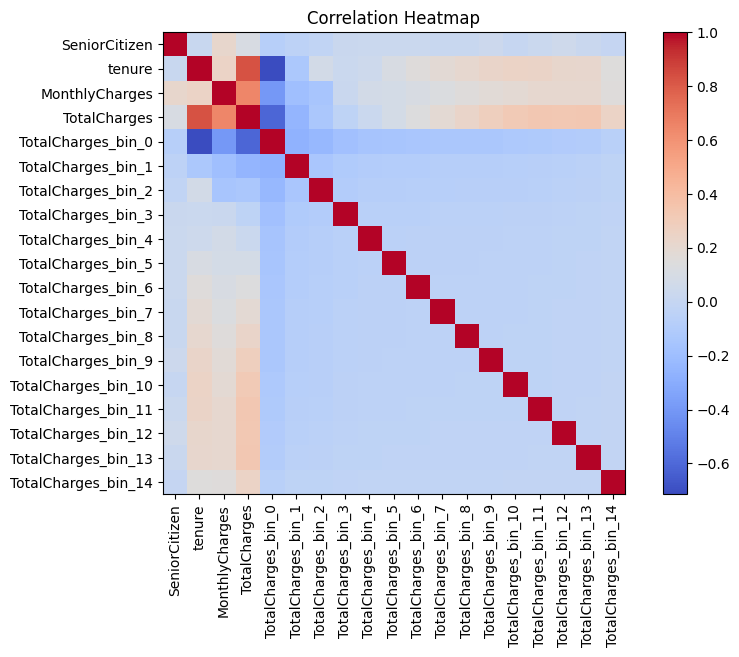

In [ ]:


# קורלציה בין פיצ'רים מספריים
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()


## Preproccesing

In [ ]:
def ensure_binary_target(df, target='Churn'):
    """
    בודק שהעמודה target היא בינארית (0/1 או bool).
    אם לא – ממיר את הערכים ל-0/1 לפי unique values.
    מחזיר את הדאטה-פריים עם העמודה מעודכנת.
    """
    import pandas as pd

    # בדיקה אם העמודה קיימת
    if target not in df.columns:
        raise ValueError(f"Column '{target}' not found in DataFrame")

    # בדיקה אם כבר bool או 0/1
    unique_vals = df[target].dropna().unique()

    # אם bool או int 0/1
    if set(unique_vals).issubset({0,1, True, False}):
        return df  # הכל בסדר, מחזירים כמו שהוא

    # אחרת, ממירים ל-0/1
    # ממיר כל ערך ייחודי ל-0 או 1 לפי סדר
    mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
    df[target] = df[target].map(mapping).astype(int)
    df = df.rename(columns={target: target})  # זה מוודא שהשם נשאר כמו שהיה

    print(f"Converted '{target}' to binary 0/1 with mapping: {mapping}")
    return df


In [ ]:
df = ensure_binary_target(df, target='Churn')


Converted 'Churn' to binary 0/1 with mapping: {'No': 0, 'Yes': 1}


### **Standard Scaler for num cols**




In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

### **Categorical get dummies ( One hot encoding )**

In [ ]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [ ]:
# בדיקה סופית

print("Shape after encoding and scaling:", df.shape)
print(df.head())

Shape after encoding and scaling: (7043, 46)
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  \
0          -0.44   -1.28           -1.16         -0.99      0   
1          -0.44    0.07           -0.26         -0.17      0   
2          -0.44   -1.24           -0.36         -0.96      1   
3          -0.44    0.51           -0.75         -0.19      0   
4          -0.44   -1.24            0.20         -0.94      1   

   TotalCharges_bin_0  TotalCharges_bin_1  TotalCharges_bin_2  \
0                True               False               False   
1               False               False               False   
2                True               False               False   
3               False               False               False   
4                True               False               False   

   TotalCharges_bin_3  TotalCharges_bin_4  ...  \
0               False               False  ...   
1                True               False  ...   
2               False  

In [ ]:
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin_0,TotalCharges_bin_1,TotalCharges_bin_2,TotalCharges_bin_3,TotalCharges_bin_4,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.44,-1.28,-1.16,-0.99,0,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,-0.44,0.07,-0.26,-0.17,0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,-0.44,-1.24,-0.36,-0.96,1,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,-0.44,0.51,-0.75,-0.19,0,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,-0.44,-1.24,0.20,-0.94,1,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.44,-0.34,0.67,-0.13,0,False,False,False,True,False,...,False,True,False,True,True,False,True,False,False,True
7039,-0.44,1.61,1.28,2.24,0,False,False,False,False,False,...,False,True,False,True,True,False,True,True,False,False
7040,-0.44,-0.87,-1.17,-0.85,0,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
7041,2.27,-1.16,0.32,-0.87,1,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


### **Imbalance Taking care 1:1**

In [ ]:
from sklearn.utils import resample
import pandas as pd

# נפריד את הקלאסים
df_majority = df[df['Churn'] == 0]
df_minority = df[df['Churn'] == 1]

# נשפר את minority class (upsample)
df_minority_upsampled = resample(
    df_minority,
    replace=True,                # דגימה עם החזרה
    n_samples=int(len(df_majority) / 1),  # נשאיר יחס ~1:2
    random_state=42
)

# נאחד חזרה
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# נערבב את השורות
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# נבדוק יחס חדש
print(df_balanced['Churn'].value_counts())


Churn
1    5174
0    5174
Name: count, dtype: int64


## **Split data to train / test**

In [ ]:
from sklearn.model_selection import train_test_split


X = df_balanced.drop(columns=['Churn'])
y = df_balanced['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **Train model**

In [ ]:

# === 7. XGBoost training ===
model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])

)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=50
)



[0]	validation_0-logloss:0.68922	validation_1-logloss:0.68939
[50]	validation_0-logloss:0.55964	validation_1-logloss:0.56682
[100]	validation_0-logloss:0.49547	validation_1-logloss:0.50850
[150]	validation_0-logloss:0.45850	validation_1-logloss:0.47686
[200]	validation_0-logloss:0.43504	validation_1-logloss:0.45793
[250]	validation_0-logloss:0.41836	validation_1-logloss:0.44557
[300]	validation_0-logloss:0.40528	validation_1-logloss:0.43612
[350]	validation_0-logloss:0.39462	validation_1-logloss:0.42915
[400]	validation_0-logloss:0.38496	validation_1-logloss:0.42339
[450]	validation_0-logloss:0.37625	validation_1-logloss:0.41829
[500]	validation_0-logloss:0.36888	validation_1-logloss:0.41427
[550]	validation_0-logloss:0.36223	validation_1-logloss:0.41062
[600]	validation_0-logloss:0.35654	validation_1-logloss:0.40764
[650]	validation_0-logloss:0.35073	validation_1-logloss:0.40455
[700]	validation_0-logloss:0.34461	validation_1-logloss:0.40126
[750]	validation_0-logloss:0.33888	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [ ]:

# חיזוי הסתברויות
y_proba = model.predict_proba(X_test)[:, 1]

# נבחר threshold חדש
threshold = 0.55
y_pred_thresh = (y_proba >= threshold).astype(int)

print(f"--- תוצאות עם threshold = {threshold} ---")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

--- תוצאות עם threshold = 0.55 ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.82      0.87      0.85      1035

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070

Confusion Matrix:
[[842 193]
 [133 902]]


## LogLoss train vs Test

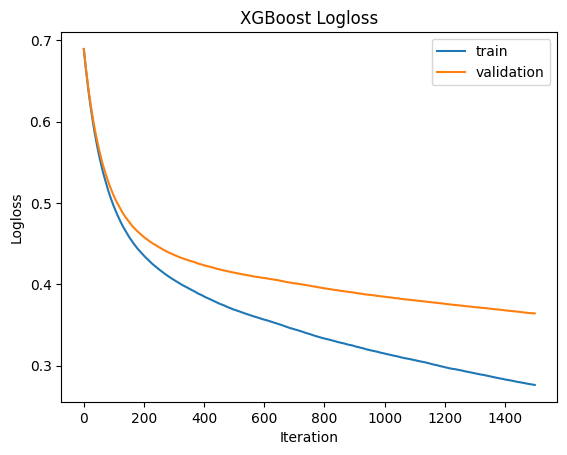

In [ ]:
import matplotlib.pyplot as plt

# --- גרף logloss ---
results = model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='validation')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss')
plt.legend()
plt.show()